# Spatial Weights

We have two general classes of spatial weights that we will look at in turn in this notebook using ['John Snow data'](https://github.com/jamesdamillington/john-snow) about the [1854 cholera outbreak in Soho](https://en.wikipedia.org/wiki/1854_Broad_Street_cholera_outbreak):

- <a href="#contig">Contiguity Weights</a>
- <a href="#distance">Distance-Based Weights</a>
    
The notebook uses the Python Spatial Analysis Library ([PySAL](https://pysal.org/)) for this analysis, and several aspects are based on [the Spatial Weights chapter of Rey et al. (2020)](https://geographicdata.science/book/notebooks/04_spatial_weights.html).  

## Setup

Required libraries:

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from libpysal import weights
from libpysal.cg.voronoi  import voronoi, voronoi_frames
import matplotlib.pyplot as plt

Load data

In [2]:
pumps = gpd.read_file('../../data/csds/snow7/pumps.shp')  #point locations of pumps
blocks = gpd.read_file('../../data/dani/polys.shp')       #polygons delineating blocks of buildings

Quick visualisation

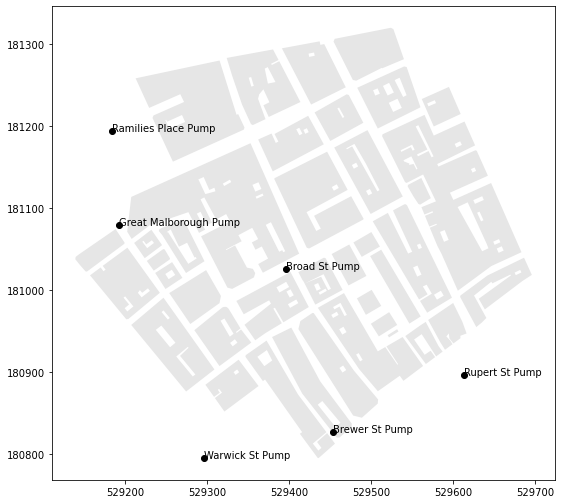

In [3]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps.plot(ax=ax, color='black')

for index, row in pumps.iterrows():
    plt.annotate(row['name'], xy=(row['geometry'].coords[0][0],row['geometry'].coords[0][1]))  

# Contiguity Weights <a name="contig"></a>

One way of defining if two areas (polygons) are neighbours, is by checking if they have contiguity (i.e. are contiguous). 

Contiguity is [defined](https://www.oed.com/view/Entry/40226?redirectedFrom=contiguity) as:

> The condition of touching or being in contact.

When working with point data we can use the [`weights.contiguity.Voronoi` function](https://pysal.org/libpysal/generated/libpysal.weights.Voronoi.html#libpysal.weights.Voronoi), which implicitly creates creates Voronoi polygons for the points:

> Points are Voronoi neighbors if their polygons share an edge or vertex.

We'll use it here with the `.from_dataframe` helper:

In [4]:
pumpsW = weights.contiguity.Voronoi.from_dataframe(pumps)

Now we have created our weights object, we can check which grid cells are neighbours using the `.neighbours` method: 

In [5]:
pumpsW.neighbors

{0: [1, 3, 4, 5], 1: [0, 2, 5], 2: [1], 3: [0, 4], 4: [0, 3, 5], 5: [0, 1, 4]}

Note that in this dictionary, the value for the key `4` is a list containing the values `0`, `3`, and `5`. This is indicating to us that the pump with index 4 in the DataFrame has three neighbours. 

To get the names of the pumps, we need to use the `ids` argument to indicate which Series of the GeoDataFrame should be used as a label:

In [6]:
pumpsW = weights.contiguity.Voronoi.from_dataframe(pumps, ids=pumps['name'].tolist())

In [7]:
pumpsW.neighbors

{'Broad St Pump': ['Rupert St Pump',
  'Brewer St Pump',
  'Great Malborough Pump',
  'Warwick St Pump'],
 'Great Malborough Pump': ['Ramilies Place Pump',
  'Broad St Pump',
  'Warwick St Pump'],
 'Ramilies Place Pump': ['Great Malborough Pump'],
 'Rupert St Pump': ['Brewer St Pump', 'Broad St Pump'],
 'Brewer St Pump': ['Rupert St Pump', 'Broad St Pump', 'Warwick St Pump'],
 'Warwick St Pump': ['Brewer St Pump',
  'Broad St Pump',
  'Great Malborough Pump']}

The `cardinalities` methods makes it easier to see the number of neighbours for eac pump:

In [8]:
pumpsW.cardinalities

{'Brewer St Pump': 3,
 'Broad St Pump': 4,
 'Great Malborough Pump': 3,
 'Ramilies Place Pump': 1,
 'Rupert St Pump': 2,
 'Warwick St Pump': 3}

And we can specify a single pump (by name as we specified which column to use for `id` above):

In [9]:
pumpsW.neighbors['Broad St Pump']

['Rupert St Pump',
 'Brewer St Pump',
 'Great Malborough Pump',
 'Warwick St Pump']

We use a matrix to define neighbourhood relations - the spatial weights object is essentially a matrix. We can view the matrix using the `.full` method: 

In [10]:
pumpsW.full()

(array([[0., 1., 0., 0., 1., 1.],
        [1., 0., 1., 0., 1., 1.],
        [0., 1., 0., 1., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.]]),
 ['Brewer St Pump',
  'Broad St Pump',
  'Great Malborough Pump',
  'Ramilies Place Pump',
  'Rupert St Pump',
  'Warwick St Pump'])

We can make this look nearer and 'more matrix-like' with some helper code:

In [11]:
pumpsWmat = pd.DataFrame(*pumpsW.full()).astype(int)  #use .astype(int) to see ints in matrix
pumpsWmat.columns = list(pumpsWmat.index)
pumpsWmat

,Brewer St Pump,Broad St Pump,Great Malborough Pump,Ramilies Place Pump,Rupert St Pump,Warwick St Pump
Brewer St Pump,0,1,0,0,1,1
Broad St Pump,1,0,1,0,1,1
Great Malborough Pump,0,1,0,1,0,1
Ramilies Place Pump,0,0,1,0,0,0
Rupert St Pump,1,1,0,0,0,0
Warwick St Pump,1,1,1,0,0,0


From this, we can see again that contiguity spatial weights are binary; a pump (based on its Thiessen polygon) either is (`1`) or is not (`0`) a neighbour with another pump. 

The matrix is read 'across': each spatial location (pump) is represented in the matrix by a row (*i*), and the potential neighbors by the columns (*j*). So as above, we can see that Brewer St Pump has neighbours Broad St, Rupert St and Warwick St by reading across the Brewer St Pump row.

We can also visualise these neighbour relations spatially:

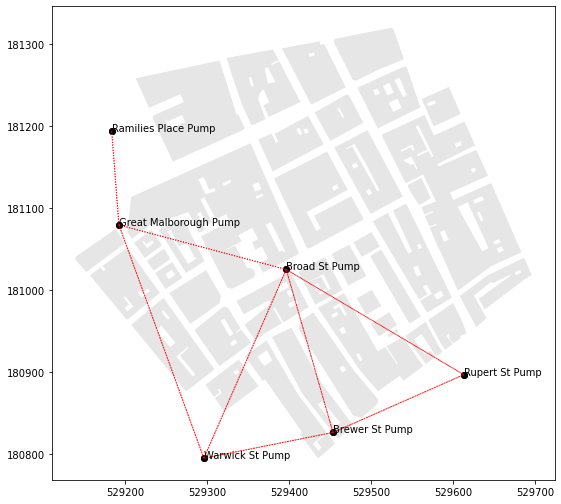

In [12]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps.plot(ax=ax, color='black')
pumpsW.plot(pumps, ax=ax, indexed_on='name', 
             edge_kws=dict(color='r', linestyle=':', linewidth=1))

for index, row in pumps.iterrows():
    plt.annotate(row['name'], xy=(row['geometry'].coords[0][0],row['geometry'].coords[0][1]))  

Let's see how these relations are indeed based on the Voronoi diagram (Thiessen polygons) for the pumps. The code below is repeated from the [Voronoi Diagram notebook](https://github.com/jamesdamillington/john-snow/blob/main/code/python/Voronoi.ipynb).

In [13]:
points = np.vstack([pumps['x'], pumps['y']]).T  
regions_df, vertices_df = voronoi_frames(points, clip='none')

(180700.0, 181400.0)

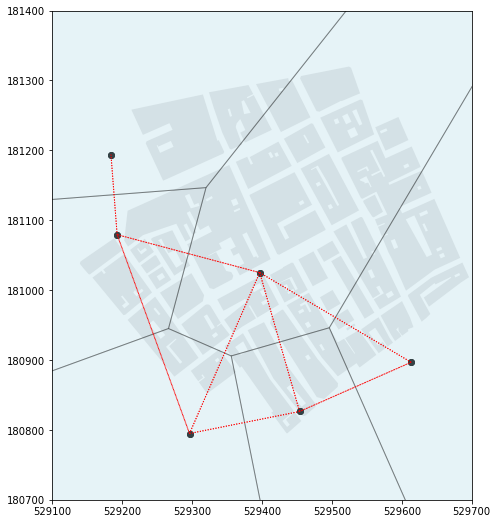

In [14]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps.plot(ax=ax, color='black')
pumpsW.plot(pumps, ax=ax, indexed_on='name', 
             edge_kws=dict(color='r', linestyle=':', linewidth=1))
regions_df.plot(ax=ax, color='lightblue',edgecolor='black', alpha=0.3)

ax.set_xlim(529100,529700)
ax.set_ylim(180700,181400) 

# Distance-Based Weights <a name="distance"></a>

Alternative to considering contiguity, we could use distance as a means to establish neighbours and spatial weights. Usually, this is done by creating a matrix that expresses distances between all pairs of observations. This matrix is then provided to a function to define neighbours and spatial weights. PySAL provides a variety of functions that could be used. Here, we'll focus on two primary functions:
1. K Nearest Neighbours (KNN)
2. Kernel Weights

## K Nearest Neighbours <a name="KNN"></a>

KNN stands for 'K Nearest Neighbours'. KNN defines the neighbors of a particular location as the _k_ with smallest distance (i.e. the nearest), where the user specifies the (integer) value of _k_. By default the [PySAL KNN weights function](https://pysal.org/libpysal/generated/libpysal.weights.KNN.html#libpysal.weights.KNN) assumes euclidean distances (not e.g. Great Circle) and a _k_ of 2. 

Let's create a spatial weights object for the Soho pumps, using `k=3` and specfying locations ids using the `name` column of the `pumps` GeoDataFrame:

In [15]:
pumpsKNN3 = weights.distance.KNN.from_dataframe(pumps, k=3, ids=pumps['name'].tolist())

By definition for `k=3`, each pump has exactly three neighbours. We can check this using the `cardinalities` method:

In [16]:
pumpsKNN3.cardinalities

{'Broad St Pump': 3,
 'Great Malborough Pump': 3,
 'Ramilies Place Pump': 3,
 'Rupert St Pump': 3,
 'Brewer St Pump': 3,
 'Warwick St Pump': 3}

Note that as for contiguity weights, the spatial weights are all binary; either a borough is (1) or is not (0) a neighbour. 

In [17]:
pumpsKNN3mat = pd.DataFrame(*pumpsKNN3.full())
pumpsKNN3mat.columns = list(pumpsKNN3mat.index)
pumpsKNN3mat

,Broad St Pump,Great Malborough Pump,Ramilies Place Pump,Rupert St Pump,Brewer St Pump,Warwick St Pump
Broad St Pump,0.0,1.0,0.0,0.0,1.0,1.0
Great Malborough Pump,1.0,0.0,1.0,0.0,0.0,1.0
Ramilies Place Pump,1.0,1.0,0.0,0.0,0.0,1.0
Rupert St Pump,1.0,0.0,0.0,0.0,1.0,1.0
Brewer St Pump,1.0,0.0,0.0,1.0,0.0,1.0
Warwick St Pump,1.0,1.0,0.0,0.0,1.0,0.0


And finally we can visualise neighbours spatially:

(180700.0, 181400.0)

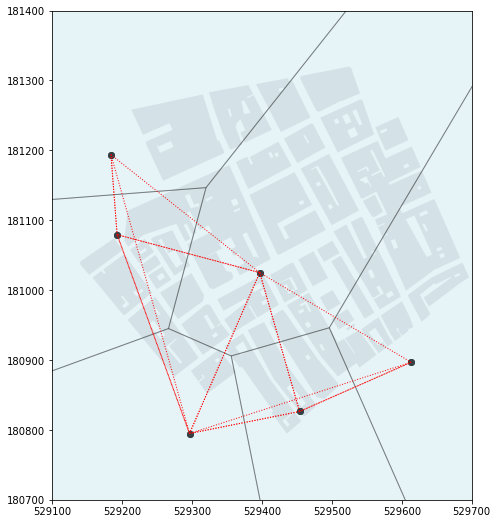

In [18]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps.plot(ax=ax, color='black')

pumpsKNN3.plot(pumps, ax=ax, indexed_on='name', 
               edge_kws=dict(color='r', linestyle=':', linewidth=1))

regions_df.plot(ax=ax, color='lightblue',edgecolor='black', alpha=0.3)
ax.set_xlim(529100,529700)
ax.set_ylim(180700,181400) 

Compare this to the previous spatial plot, noting how there are more neighbour relations defined here. 

And we can add some labels to further help the visualisation:

(180700.0, 181400.0)

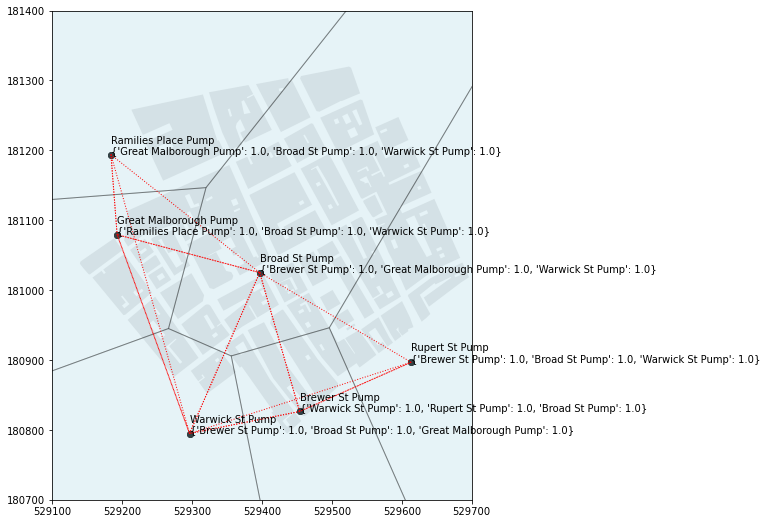

In [19]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps.plot(ax=ax, color='black')

pumpsKNN3.plot(pumps, ax=ax, indexed_on='name', 
               edge_kws=dict(color='r', linestyle=':', linewidth=1))

regions_df.plot(ax=ax, color='lightblue',edgecolor='black', alpha=0.3)

for index, row in pumps.iterrows():
    b=row['name']
    plt.annotate('{0}\n{1}'.format(b,pumpsKNN3[b]),
                 xy=(pumps.centroid[index].coords[0][0], pumps.centroid[index].coords[0][1]))

ax.set_xlim(529100,529700)
ax.set_ylim(180700,181400) 

## Kernel <a name="kernel"></a>

All the techniques for specifying spatial neighbour relations so far have been binary: locations are either neighbours or they are not. However, for locations that are neighbours we could also consider varying the weight or 'strength' of the relationship. **Kernel weights** allows this latter approach. 

In statistics, a [kernel](https://en.wikipedia.org/wiki/Kernel_(statistics)) is a [window function](https://en.wikipedia.org/wiki/Window_function), meaning that beyond some distance (the 'window' or 'bandwidth') a weight will be zero. Within the window the weight is defined by the kernel function. 

PySAL offers several kernel functions, all of which exhibit [distance decay](https://en.wikipedia.org/wiki/Distance_decay). Thus, these kernel functions encode Tobler's first law; observations closer to a location have larger valued weights than more distant observations. 

Kernel functions [available in PySAL](https://pysal.org/libpysal/generated/libpysal.weights.Kernel.html) are:
- triangular
- uniform
- quadratic ('Epanechnikov')
- quartic
- gaussian

[In PySAL](https://geographicdata.science/book/notebooks/04_spatial_weights.html#kernel-weights):

> The default values for kernels are to use a triangular kernel with a bandwidth distance equal to the maximum knn=2 distance for all observations. The latter implies a so-called fixed bandwidth were all observations use the same distance for the cut-off.

In PySAL we use the [`Kernel` function](https://pysal.org/libpysal/generated/libpysal.weights.Kernel.html) to create spatial weights objects using kernel functions. 

Let's create a spatial weights object using the defaults (triangular kernel with bandwidth specified by *KNN=2*) and we'll specify pump labels for ids: 

In [20]:
pumpsK = weights.distance.Kernel.from_dataframe(pumps, ids=pumps['name'].tolist())

We can check the kernel function used, from the `function` attribute:

In [21]:
pumpsK.function

'triangular'

Let's look at the spatial weights matrix produced:

In [22]:
pumpsKmat = round(pd.DataFrame(*pumpsK.full()),3)   #note, not focing to int!
pumpsKmat.columns = list(pumpsKmat.index)
pumpsKmat

,Broad St Pump,Great Malborough Pump,Ramilies Place Pump,Rupert St Pump,Brewer St Pump,Warwick St Pump
Broad St Pump,1.000,0.223,0.000,0.073,0.239,0.075
Great Malborough Pump,0.223,1.000,0.578,0.000,0.000,0.000
Ramilies Place Pump,0.000,0.578,1.000,0.000,0.000,0.000
Rupert St Pump,0.073,0.000,0.000,1.000,0.357,0.000
Brewer St Pump,0.239,0.000,0.000,0.357,1.000,0.409
Warwick St Pump,0.075,0.000,0.000,0.000,0.409,1.000


Note how, different from contiguity and KNN weights, **the spatial weights are continous**. Kernel weights are _not_ binary, rather they take a continuous value based on distance and dependent on the kernel function being used. With this approach we specify not only which Borough are neighbours but also which are more related to one another (by distance) than others.  

The number of neighbours defined by a kernel function varies depending on the bandwidth specified (and the function used). In this case we have used the defaults (`triangular` kernel with bandwidth specified by *KNN=2*), giving us the following number of neighbours:

In [23]:
pumpsK.cardinalities

{'Broad St Pump': 6,
 'Great Malborough Pump': 3,
 'Ramilies Place Pump': 3,
 'Rupert St Pump': 3,
 'Brewer St Pump': 4,
 'Warwick St Pump': 3}

Note that the minimum number of neighbours is 3, even though the default specifies KNN=2. This is because for some reason the focal location is included in the neighbour count (k attribute) of spatial weights objects created using the PySAL Kernel function. 

We can check what bandwidth was calculated from the _bandwidth_ attribute (specifying that we only want to see the first five values):

In [24]:
pumpsK.bandwidth

array([[271.53992114],
       [271.53992114],
       [271.53992114],
       [271.53992114],
       [271.53992114],
       [271.53992114]])

This bandwidth was specified based on the longest distance for all pumps to have a minimum of two neighbours. (the KNN=2 bit of the default setting). So the bandwidth as been dynamically calculated based on the minimum number of neighbours we think our pumps should have. 

But remember that we can over-ride this and specify the bandwidth explicitly ourselves. Let's see this by creating a new spatialweights object with a slightly smaller bandwidth (`270` vs `271.5`): 

In [25]:
pumpsK270 = weights.distance.Kernel.from_dataframe(pumps, function='triangular', 
                                                bandwidth=270, 
                                                ids=pumps['name'].tolist())

In [26]:
pumpsK270.bandwidth

array([[270.],
       [270.],
       [270.],
       [270.],
       [270.],
       [270.]])

In [27]:
pumpsK270.cardinalities   

{'Broad St Pump': 5,
 'Great Malborough Pump': 3,
 'Ramilies Place Pump': 2,
 'Rupert St Pump': 3,
 'Brewer St Pump': 4,
 'Warwick St Pump': 3}

From this output (compared to above) we can see:
- some pumps have the same number of neighbours in both cases 
- some pumps have fewer neighbours for the smaller bandwidth

What about the weights of the neighbours? Let's compare the weights for the two Kernel function spatial weights objects we've created:

In [28]:
pumpsK270mat = round(pd.DataFrame(*pumpsK270.full()),3)
pumpsK270mat.columns = list(pumpsK270mat.index)
pumpsK270mat

,Broad St Pump,Great Malborough Pump,Ramilies Place Pump,Rupert St Pump,Brewer St Pump,Warwick St Pump
Broad St Pump,1.000,0.218,0.000,0.067,0.234,0.070
Great Malborough Pump,0.218,1.000,0.575,0.000,0.000,0.000
Ramilies Place Pump,0.000,0.575,1.000,0.000,0.000,0.000
Rupert St Pump,0.067,0.000,0.000,1.000,0.354,0.000
Brewer St Pump,0.234,0.000,0.000,0.354,1.000,0.405
Warwick St Pump,0.070,0.000,0.000,0.000,0.405,1.000


Compareing this weights matrix to the previous one, we can see that the weights values differ slightly between the two bandwiths. Remember this is for the *triangular* kernel function, [which looks like this](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Kernel_triangle.svg/600px-Kernel_triangle.svg.png), so that makes sense. 

But what if we used the uniform function? (which [looks like this](https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/Kernel_uniform.svg/600px-Kernel_uniform.svg.png)). First using the defaults:

In [29]:
pumpsKu = weights.distance.Kernel.from_dataframe(pumps, function='uniform', ids=pumps['name'].tolist())
pumpsKumat = pd.DataFrame(*pumpsKu.full())
pumpsKumat.columns = list(pumpsKumat.index)
print(pumpsKu.bandwidth)
pumpsKumat

[[271.53992114]
 [271.53992114]
 [271.53992114]
 [271.53992114]
 [271.53992114]
 [271.53992114]]


,Broad St Pump,Great Malborough Pump,Ramilies Place Pump,Rupert St Pump,Brewer St Pump,Warwick St Pump
Broad St Pump,0.5,0.5,0.5,0.5,0.5,0.5
Great Malborough Pump,0.5,0.5,0.5,0.0,0.0,0.0
Ramilies Place Pump,0.5,0.5,0.5,0.0,0.0,0.0
Rupert St Pump,0.5,0.0,0.0,0.5,0.5,0.0
Brewer St Pump,0.5,0.0,0.0,0.5,0.5,0.5
Warwick St Pump,0.5,0.0,0.0,0.0,0.5,0.5


Now using a shorter bandwidth:

In [30]:
pumpsKu270 = weights.distance.Kernel.from_dataframe(pumps, function='uniform', 
                                                    bandwidth=270, ids=pumps['name'].tolist())
pumpsKu270mat = pd.DataFrame(*pumpsKu270.full())
pumpsKu270mat.columns = list(pumpsKu270mat.index)
print(pumpsKu270.bandwidth)
pumpsKu270mat

[[270.]
 [270.]
 [270.]
 [270.]
 [270.]
 [270.]]


,Broad St Pump,Great Malborough Pump,Ramilies Place Pump,Rupert St Pump,Brewer St Pump,Warwick St Pump
Broad St Pump,0.5,0.5,0.0,0.5,0.5,0.5
Great Malborough Pump,0.5,0.5,0.5,0.0,0.0,0.0
Ramilies Place Pump,0.0,0.5,0.5,0.0,0.0,0.0
Rupert St Pump,0.5,0.0,0.0,0.5,0.5,0.0
Brewer St Pump,0.5,0.0,0.0,0.5,0.5,0.5
Warwick St Pump,0.5,0.0,0.0,0.0,0.5,0.5


Now we see that *the weights for all neighbours is the same*. This makes sense for the _uniform_ function. 

Check you understand the reason why we get different weights for different bandwiths with the _triangular_ function, but not the _uniform_ function. 

Let's visualise the differences spatially. First we create a function we can use to compare plots of neighbour weights below:

In [31]:
def plotKernel(wKernel, gpDF, focal, myAx):
    
    #bins and their labels
    EQbins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    labs = []
    for i,val in enumerate(EQbins):
        if(i > 0):
            labs.append('{0}-{1}'.format(EQbins[i-1],EQbins[i]))
    
    #get the full matrix for this kernel 
    full_matrix, ids = wKernel.full() 
    full_matrix[full_matrix==0] = np.nan
    
    
    gpDF.plot(ax=myAx, facecolor='None', edgecolor='k')
    gpDF.assign(cats = pd.cut(full_matrix[ids.index(focal)],
                                    bins=EQbins, labels=labs, duplicates='drop')).plot('cats', ax=myAx,
                                                                                       cmap='viridis', alpha=0.8,
                                                           legend=True, legend_kwds={'loc': 'upper right'})
  
    #set titles
    myAx.set_title('{0}, {1}, k = {2}, b = {3}'.format(focal, wKernel.function, 
                                                       wKernel.k, int(wKernel.bandwidth[0])))
    myAx.get_legend().set_title("Weight")

    myAx.set_axis_off()

We can use this function to visualise the neighbour weights for a `focal` pump and a given spatial weights object (`wKernel`). 

For example, to visualise neighbours of Broad St Pump for the initial kernel spatial weights object we created above (using all defaults):

(180700.0, 181400.0)

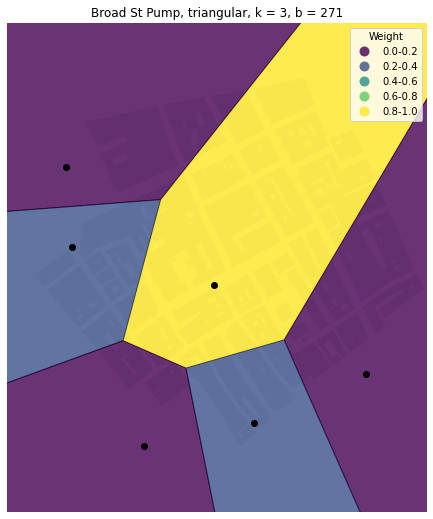

In [32]:
fig, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
plotKernel(pumpsK, regions_df, 'Broad St Pump', ax)
pumps.plot(ax=ax, color='black')
ax.set_xlim(529100,529700)
ax.set_ylim(180700,181400) 

It's difficult to see the distance decay nature of the _triangular_ function here, but it is there...

Let's use a loop to compare weights for different functions with the same bandwidth:

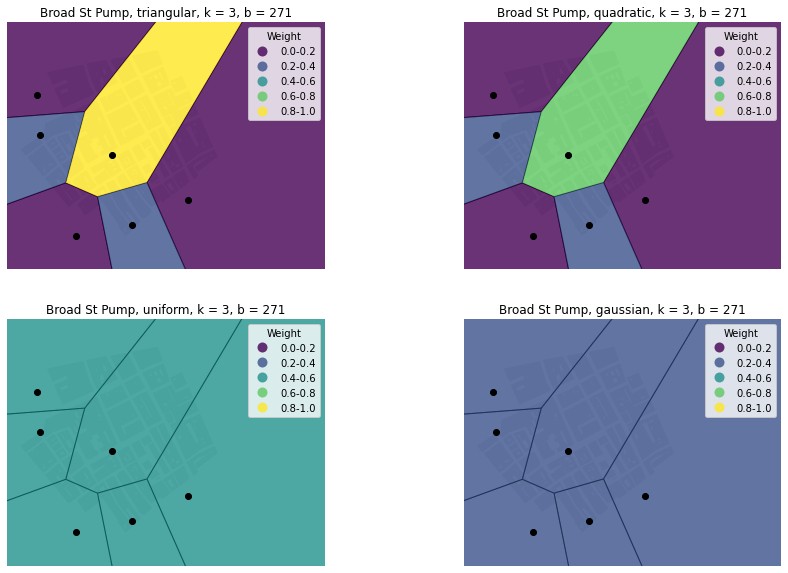

In [33]:
fig, axes = plt.subplots(2,2, figsize=(15, 10))

fList = ['triangular','quadratic','uniform','gaussian']

for ax, f in zip(axes.flat, fList):
    
    blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
    
    myKernel = weights.distance.Kernel.from_dataframe(pumps, function=f, ids=pumps['name'].tolist())
    plotKernel(myKernel, regions_df, 'Broad St Pump', ax)
    
    pumps.plot(ax=ax, color='black')
    ax.set_xlim(529100,530000)
    ax.set_ylim(180700,181400) 

The weights (of 'neighbourlyness') vary depending on the kernel function being used. 

NB: Remember that in the titles above k is always 1 greater than the k specified in the code (because for some reason the focal location is included in the neighbour count of spatial weights objects created using the PySAL Kernel function). 

And let's look at another visualisation, this time for a single kernel function but different bandwidths each time:

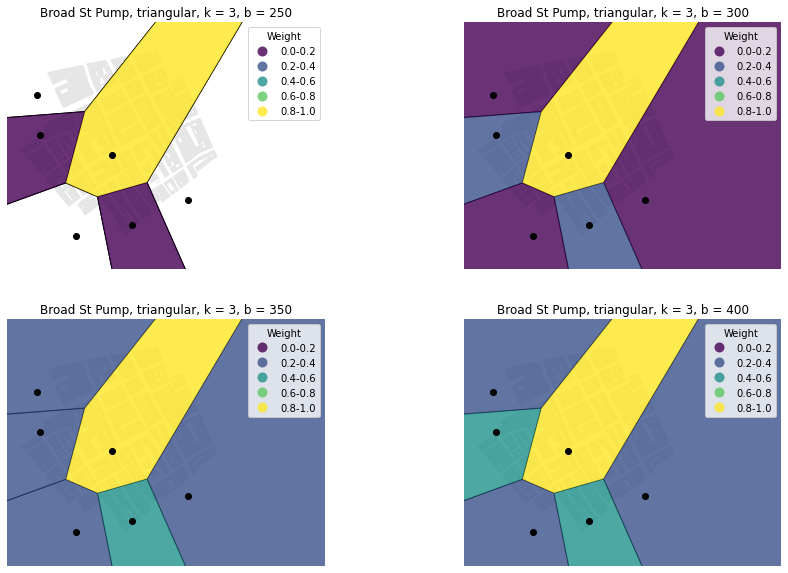

In [34]:
f, axes = plt.subplots(2,2, figsize=(15, 10))

bList = range(250, 450, 50)

for ax, b in zip(axes.flat, bList):
    
    blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
    
    myKernel = weights.distance.Kernel.from_dataframe(pumps, bandwidth=b, ids=pumps['name'].tolist())
    plotKernel(myKernel, regions_df, 'Broad St Pump', ax)
    
    pumps.plot(ax=ax, color='black')
    ax.set_xlim(529100,530000)
    ax.set_ylim(180700,181400) 

In this case we can ignore the _k_ value in the plot titles. 

Note how for larger bandwith we have more neighbours _and_ the weights for neighbours can change. 

Finally, another argument in the [PySAL `Kernel` function](https://pysal.org/libpysal/generated/libpysal.weights.Kernel.html) we can vary is `diagonal` - this specifies whether the weight the of the focal locations should be forced to equal 1.0 (when `TRUE`) or whether it should just take the value specified by the function (`FALSE`). From the figures showing the different types of kernel above we can see that for the triangle function, the focal location will always have a weight of 1.0, but not for the other functions. 

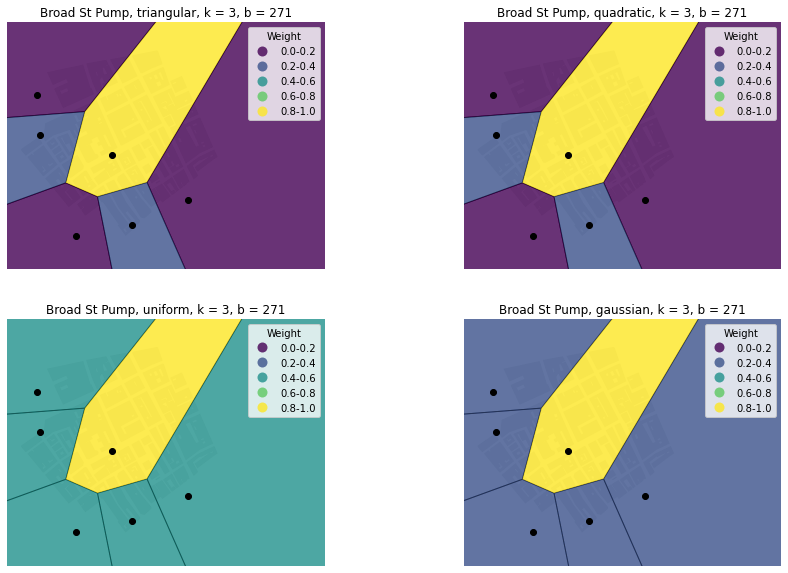

In [35]:
fig, axes = plt.subplots(2,2, figsize=(15, 10))

fList = ['triangular','quadratic','uniform','gaussian']

for ax, f in zip(axes.flat, fList):
    
    blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
    
    myKernel = weights.distance.Kernel.from_dataframe(pumps, 
                                                      function=f, 
                                                      diagonal=True,
                                                      ids=pumps['name'].tolist())
    plotKernel(myKernel, regions_df, 'Broad St Pump', ax)
    
    pumps.plot(ax=ax, color='black')
    ax.set_xlim(529100,530000)
    ax.set_ylim(180700,181400) 

By specifying `diagonal=True` we see that Broad St Pump (the focal location) _always_ has a weight of 1.0. This can be useful in future when working with spatial autocorrelation or regression. 

# Further Activities

- Explore [adaptive bandwidth](https://geographicdata.science/book/notebooks/04_spatial_weights.html#kernel-weights) and [hybrid weights](https://geographicdata.science/book/notebooks/04_spatial_weights.html#distance-bands-and-hybrid-weights) as extensions to the weights methods examined in this notebook
- Continue to read about how spatial weights are used in [Spatial Autocorrelation](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html)
- Investigate other uses of spatial weights, such as [spatial lag](https://darribas.org/gds15/content/labs/lab_06.html#Spatial-lag) 

# Credits!

## Contributors:
The following individual(s) have contributed to these teaching materials: James Millington (james.millington@kcl.ac.uk).

## License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).